# Estimating Gestational Diabetes Onset

## Data Wrangling and EDA

### Gathering the data

<p>All of the data had been saved to a mobile app called One Touch Reveal, a popular tracking app for ppeople with diabetes and their healthcare professionals. I was able to log into the website application and load a report with all of my data and although there was an export function it was unhelpful for this project; it compiled a pdf file. There was also an API working to generate the report, but it was not accessible to me.</p>
<p>I ended up scraping the data via a javascript function that I run directly on the page. The output was a JSON string that I then copied and pasted into a file that I could then import below.</p>
<p>Here is the javascript function that I used:</p>

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

### Load the data

In [2]:
data = pd.read_json('data/onetouch.json')
data.columns = ['type', 'timestamp', 'value', 'notes']

In [3]:
data.head()

,type,timestamp,value,notes
0,BG,"Mar 11, 2021 7:11:14 am",104 mg/dL,Before Meal
1,BG,"Mar 11, 2021 9:20:03 am",121 mg/dL,"No Tag, 20 minutes late... Struggled with punc..."
2,BG,"Mar 11, 2021 2:35:58 pm",119 mg/dL,No Tag
3,BG,"Mar 11, 2021 7:54:56 pm",87 mg/dL,"No Tag, Might have tested slightly before an h..."
4,Carbs,"Mar 11, 2021 8:01:00 am",26 g,


**Let's fix some datatypes!**

In [4]:
data.dtypes

type         object
timestamp    object
value        object
notes        object
dtype: object

In [5]:
data.timestamp = pd.to_datetime(data.timestamp)

In [6]:
data.value = data.value.str.extract('(\d+)', expand=False).astype(int)

In [7]:
data.dtypes

type                 object
timestamp    datetime64[ns]
value                 int64
notes                object
dtype: object

**We need an index. Since this is a timeseries it should be the timeseries**

In [8]:
# Double check that all of the indeces are unique
len(data.timestamp.unique()), len(data)

(726, 726)

In [9]:
# Good to go!
data.set_index('timestamp', inplace=True)
data.sort_index(inplace=True)

In [10]:
data.head()

,type,value,notes
timestamp,,,
2021-03-11 07:11:14,BG,104,Before Meal
2021-03-11 08:01:00,Carbs,26,
2021-03-11 09:20:03,BG,121,"No Tag, 20 minutes late... Struggled with punc..."
2021-03-11 11:18:00,Carbs,27,
2021-03-11 13:30:00,Carbs,30,


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 2021-03-11 07:11:14 to 2021-05-25 21:40:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    726 non-null    object
 1   value   726 non-null    int64 
 2   notes   726 non-null    object
dtypes: int64(1), object(2)
memory usage: 22.7+ KB


### Light Data Visualization

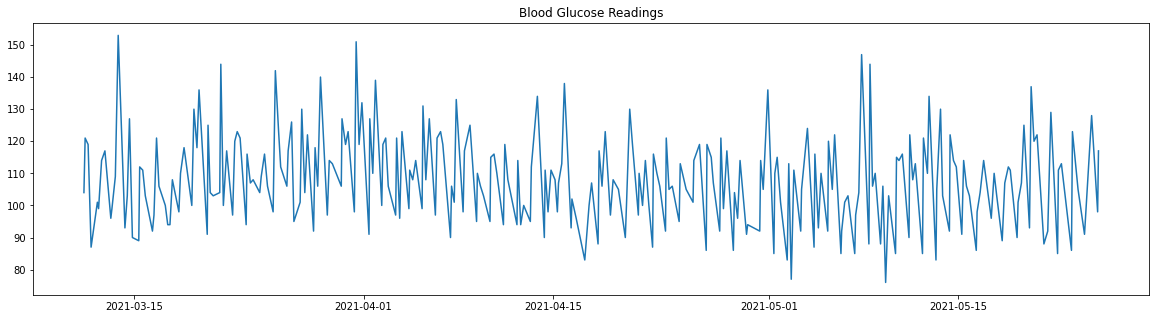

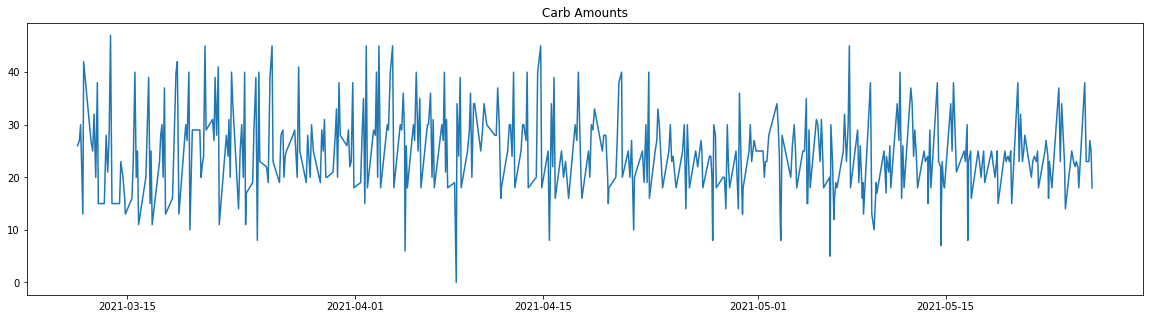

In [27]:
bg = data[data.type == 'BG']

plt.figure(figsize=(20,5))
plt.plot(bg.index, bg.value)
plt.title('Blood Glucose Readings')
plt.show()

carb = data[data.type == 'Carbs']

plt.figure(figsize=(20,5))
plt.plot(carb.index, carb.value)
plt.title('Carb Amounts')
plt.show()

### Feature Extraction
<ul>
    <li>'month': calendar month</li>
    <li>'daycount': days since the first reading</li>
    <li>'subtype'</li>
</ul>

In [13]:
# calendar month
data['month'] = data.index.month

In [35]:
#days since the first reading
# make a list of days
days = pd.DataFrame(np.unique(data.index.date))
days.index += 1 
days.reset_index().set_index(0)
days = days.to_dict()[0]
days = {v: k for k, v in days.items()}


In [37]:
import itertools

dict(itertools.islice(days.items(), 0 ,5))

{datetime.date(2021, 3, 11): 1,
 datetime.date(2021, 3, 12): 2,
 datetime.date(2021, 3, 13): 3,
 datetime.date(2021, 3, 14): 4,
 datetime.date(2021, 3, 15): 5}

In [15]:
# make new column and map day to timestamp
data['date'] = data.index.date
data['daycount'] = data['date'].map(days)
data

,type,value,notes,month,date,daycount
timestamp,,,,,,
2021-03-11 07:11:14,BG,104,Before Meal,3,2021-03-11,1
2021-03-11 08:01:00,Carbs,26,,3,2021-03-11,1
2021-03-11 09:20:03,BG,121,"No Tag, 20 minutes late... Struggled with punc...",3,2021-03-11,1
2021-03-11 11:18:00,Carbs,27,,3,2021-03-11,1
2021-03-11 13:30:00,Carbs,30,,3,2021-03-11,1
...,...,...,...,...,...,...
2021-05-25 11:08:00,Carbs,23,,5,2021-05-25,76
2021-05-25 15:47:00,Carbs,23,,5,2021-05-25,76
2021-05-25 17:39:00,Carbs,27,,5,2021-05-25,76


In [16]:
data[data.type == 'BG'].daycount.value_counts()
dict(itertools.islice(data.items(), 0 ,5))

36    5
43    5
1     4
56    4
2     4
     ..
38    3
37    3
50    2
75    2
76    2
Name: daycount, Length: 76, dtype: int64

In [38]:
data[(data.type == 'BG') & ((data.daycount == 36) | (data.daycount == 43))]

,type,value,notes,month,date,daycount,subtype
timestamp,,,,,,,
2021-04-15 04:08:16,BG,108,No Tag,4,2021-04-15,36,NaN
2021-04-15 08:16:44,BG,98,No Tag,4,2021-04-15,36,NaN
2021-04-15 10:18:39,BG,107,No Tag,4,2021-04-15,36,NaN
2021-04-15 16:05:45,BG,113,No Tag,4,2021-04-15,36,NaN
2021-04-15 20:45:09,BG,138,No Tag,4,2021-04-15,36,NaN
2021-04-22 02:50:58,BG,100,No Tag,4,2021-04-22,43,NaN
2021-04-22 09:27:01,BG,87,"No Tag, This is actually my fasting number.",4,2021-04-22,43,NaN
2021-04-22 10:54:34,BG,116,No Tag,4,2021-04-22,43,NaN
2021-04-22 17:06:28,BG,110,No Tag,4,2021-04-22,43,NaN


**We don't need the overnight BG readings for this application**

In [46]:
data[data.index.hour < 5]

,type,value,notes,month,date,daycount,subtype
timestamp,,,,,,,
2021-04-15 04:08:16,BG,108,No Tag,4,2021-04-15,36,NaN
2021-04-22 02:50:58,BG,100,No Tag,4,2021-04-22,43,NaN


In [50]:
data.drop(data[data.index.hour < 5].index, inplace=True)

In [56]:
data[data.type == 'BG'].daycount.value_counts()

1     4
56    4
36    4
2     4
41    4
42    4
43    4
44    4
47    4
48    4
49    4
51    4
52    4
53    4
55    4
57    4
33    4
58    4
59    4
60    4
61    4
62    4
63    4
64    4
65    4
66    4
67    4
69    4
70    4
71    4
35    4
39    4
18    4
9     4
11    4
12    4
13    4
14    4
15    4
16    4
17    4
8     4
7     4
6     4
20    4
21    4
22    4
23    4
24    4
5     4
4     4
25    4
26    4
27    4
28    4
3     4
30    4
31    4
10    4
68    3
72    3
73    3
74    3
32    3
34    3
54    3
19    3
46    3
45    3
40    3
29    3
38    3
37    3
50    2
75    2
76    2
Name: daycount, dtype: int64

**Subtypes**

In [21]:
# loop through daycounts to save subtypes
# BG: fasting, meal
# Carbs: breakfast, snack, lunch, dinner

# delete any readings between midnight and 5am

def add_subtypes(df):
    
    #df.subtype = ''

    for i in range(1, len(df.daycount.unique())): 
        df_day = df[df.daycount == i]
        bg = df_day[df_day.type == 'BG']
        carbs = df_day[df_day.type == 'Carbs']
        
        bg_subtypes = ['fasting', 'meal', 'meal', 'meal']
        carbs_subtypes = ['breakfast', 'snack_morning', 'lunch', 'snack_afternoon', 'dinner', 'snack_night']
        subtypes = ['fasting', 'breakfast', 'post_meal', 'snack_morning', 'lunch', 'post_meal', 'snack_afternoon', 'dinner', 'post_meal', 'snack_night']
        
        num_all = len(df_day)
        num_bg = len(bg)
        num_carbs = len(carbs)
        
        if ((num_bg == 4) & (num_carbs == 6)):
            #print('day',df_day.loc[df_day.iloc[0].name].daycount, 'counts', num_all, num_bg, num_carbs)
            for d in range(num_all):
                df.loc[df_day.iloc[d].name, 'subtype'] = subtypes[d]
                
        
        # if there are 4 BGs
#         if len(bg) == 5:
#             bg.drop(bg.iloc[0].name, inplace=True)
#             df.drop(bg.iloc[0].name, inplace=True)
#         if len(bg) == 4:
#             for b in range(len(bg)):
#                 df.loc[bg.iloc[b].name, 'subtype'] = bg_subtypes[b]
            
#         # if there are 6 Carbs
#         if len(carbs) == 6:
#             for c in range(len(carbs)):
#                 df.loc[carbs.iloc[c].name, 'subtype'] = carbs_subtypes[c]
            
        
    return df
    
add_subtypes(data)
data.head(20)

,type,value,notes,month,date,daycount,subtype
timestamp,,,,,,,
2021-03-11 07:11:14,BG,104,Before Meal,3,2021-03-11,1,NaN
2021-03-11 08:01:00,Carbs,26,,3,2021-03-11,1,NaN
2021-03-11 09:20:03,BG,121,"No Tag, 20 minutes late... Struggled with punc...",3,2021-03-11,1,NaN
2021-03-11 11:18:00,Carbs,27,,3,2021-03-11,1,NaN
2021-03-11 13:30:00,Carbs,30,,3,2021-03-11,1,NaN
2021-03-11 14:35:58,BG,119,No Tag,3,2021-03-11,1,NaN
2021-03-11 17:30:00,Carbs,13,,3,2021-03-11,1,NaN
2021-03-11 18:55:00,Carbs,42,,3,2021-03-11,1,NaN
2021-03-11 19:54:56,BG,87,"No Tag, Might have tested slightly before an h...",3,2021-03-11,1,NaN


In [77]:
# schedule
data_with_subtypes = data[~data.subtype.isnull()]
carb_schedule = {
    'fasting': data_with_subtypes[data_with_subtypes.subtype == 'fasting'].index.hour.unique().sort_values().values,
    'breakfast': data_with_subtypes[data_with_subtypes.subtype == 'breakfast'].index.hour.unique().sort_values().values,
    'snack_morning': data_with_subtypes[data_with_subtypes.subtype == 'snack_morning'].index.hour.unique().sort_values().values,
    'lunch': data_with_subtypes[data_with_subtypes.subtype == 'lunch'].index.hour.unique().sort_values().values,
    'snack_afternoon': data_with_subtypes[data_with_subtypes.subtype == 'snack_afternoon'].index.hour.unique().sort_values().values,
    'dinner': data_with_subtypes[data_with_subtypes.subtype == 'dinner'].index.hour.unique().sort_values().values,
    'snack_night': data_with_subtypes[data_with_subtypes.subtype == 'snack_night'].index.hour.unique().sort_values().values,
}
carb_schedule

{'fasting': array([ 6,  7,  8,  9, 10]),
 'breakfast': array([ 7,  8,  9, 10, 11]),
 'snack_morning': array([10, 11, 12, 13]),
 'lunch': array([13, 14, 15, 16]),
 'snack_afternoon': array([15, 16, 17, 18]),
 'dinner': array([17, 18, 19, 20]),
 'snack_night': array([20, 21, 22])}

In [65]:
# Lunch times

data[(~data.subtype.isnull()) & (data.subtype == 'lunch')].index.hour.unique()

Int64Index([13, 14, 15, 16], dtype='int64', name='timestamp')

In [66]:
# Dinner times

data[(~data.subtype.isnull()) & (data.subtype == 'dinner')].index.hour.unique()

Int64Index([19, 18, 20, 17], dtype='int64', name='timestamp')

In [22]:
data[data.subtype.isnull()].type.value_counts()

Carbs    260
BG       166
Name: type, dtype: int64

In [23]:
# figure out the non-standard days' subtypes
# Carbs: 


weirdays = data[data.subtype.isnull()]
weirdays[(weirdays.type == 'Carbs') & (weirdays.value > 30)]

,type,value,notes,month,date,daycount,subtype
timestamp,,,,,,,
2021-03-11 18:55:00,Carbs,42,,3,2021-03-11,1,NaN
2021-03-16 15:09:00,Carbs,39,,3,2021-03-16,6,NaN
2021-03-18 16:01:00,Carbs,40,,3,2021-03-18,8,NaN
2021-03-18 18:24:00,Carbs,42,,3,2021-03-18,8,NaN
2021-03-19 15:05:00,Carbs,40,,3,2021-03-19,9,NaN
2021-03-23 18:45:00,Carbs,40,,3,2021-03-23,13,NaN
2021-03-25 16:03:00,Carbs,39,,3,2021-03-25,15,NaN
2021-03-25 19:42:00,Carbs,45,,3,2021-03-25,15,NaN
2021-03-27 19:15:00,Carbs,41,,3,2021-03-27,17,NaN


In [ ]:
# loop through daycounts to build out daily_data
# save daily BG avg, carb sum, number of readings?

In [26]:
pd.set_option('display.max_rows', 500)

weirdays.reset_index().set_index(['daycount', 'timestamp'])

type  value  \
daycount timestamp                           
1        2021-03-11 07:11:14     BG    104   
         2021-03-11 08:01:00  Carbs     26   
         2021-03-11 09:20:03     BG    121   
         2021-03-11 11:18:00  Carbs     27   
         2021-03-11 13:30:00  Carbs     30   
         2021-03-11 14:35:58     BG    119   
         2021-03-11 17:30:00  Carbs     13   
         2021-03-11 18:55:00  Carbs     42   
         2021-03-11 19:54:56     BG     87   
4        2021-03-14 08:01:21     BG     93   
         2021-03-14 11:04:00  Carbs     15   
         2021-03-14 12:12:47     BG    103   
         2021-03-14 13:25:00  Carbs     23   
         2021-03-14 16:05:54     BG    127   
         2021-03-14 17:10:00  Carbs     20   
         2021-03-14 20:13:00  Carbs     16   
         2021-03-14 21:18:29     BG     90   
         2021-03-14 21:30:00  Carbs     13   
6        2021-03-16 08:55:23     BG     92   
         2021-03-16 10:09:00  Carbs     20   
         2021-03-16 11:38:21     BG     97   
         2021-03-16 15:09:00  Carbs     39   
         2021-03-16 16:10:33     BG    121   
         2021-03-16 17:40:00  Carbs     15   
         2021-03-16 19:22:00  Carbs     25   
         2021-03-16 20:27:01     BG    106   
         2021-03-16 21:25:00  Carbs     11   
8        2021-03-18 07:53:36     BG     98   
         2021-03-18 09:45:00  Carbs     16   
         2021-03-18 10:45:51     BG    110   
         2021-03-18 12:10:00  Carbs     25   
         2021-03-18 16:01:00  Carbs     40   
         2021-03-18 17:02:12     BG    118   
         2021-03-18 18:24:00  Carbs     42   
         2021-03-18 19:24:08     BG    115   
         2021-03-18 21:12:00  Carbs     13   
9        2021-03-19 06:50:27     BG    100   
         2021-03-19 09:27:00  Carbs     30   
         2021-03-19 10:35:52     BG    130   
         2021-03-19 11:48:00  Carbs     27   
         2021-03-19 15:05:00  Carbs     40   
         2021-03-19 15:59:49     BG    118   
         2021-03-19 16:55:00  Carbs     10   
         2021-03-19 19:40:55     BG    136   
         2021-03-19 21:09:00  Carbs     29   
13       2021-03-23 07:23:56     BG     94   
         2021-03-23 07:48:00  Carbs     14   
         2021-03-23 09:00:23     BG    116   
         2021-03-23 10:42:00  Carbs     25   
         2021-03-23 13:30:00  Carbs     30   
         2021-03-23 14:53:26     BG    107   
         2021-03-23 16:20:00  Carbs     20   
         2021-03-23 18:45:00  Carbs     40   
         2021-03-23 19:48:06     BG    108   
         2021-03-23 20:24:00  Carbs     11   
         2021-03-23 21:47:00  Carbs     17   
15       2021-03-25 07:18:05     BG     98   
         2021-03-25 09:56:00  Carbs     22   
         2021-03-25 11:16:02     BG    142   
         2021-03-25 12:50:00  Carbs     19   
         2021-03-25 16:03:00  Carbs     39   
         2021-03-25 17:03:07     BG    123   
         2021-03-25 19:42:00  Carbs     45   
         2021-03-25 20:42:39     BG    112   
         2021-03-25 21:29:00  Carbs     23   
17       2021-03-27 07:18:07     BG    101   
         2021-03-27 09:08:00  Carbs     28   
         2021-03-27 10:10:54     BG    130   
         2021-03-27 12:10:00  Carbs     29   
         2021-03-27 15:35:05     BG    104   
         2021-03-27 16:40:00  Carbs     20   
         2021-03-27 19:15:00  Carbs     41   
         2021-03-27 20:17:37     BG    122   
         2021-03-27 21:25:00  Carbs     25   
19       2021-03-29 07:34:17     BG     97   
         2021-03-29 09:58:00  Carbs     19   
         2021-03-29 11:03:18     BG    114   
         2021-03-29 12:37:00  Carbs     29   
         2021-03-29 15:15:00  Carbs     25   
         2021-03-29 16:31:52     BG    113   
         2021-03-29 17:20:00  Carbs     31   
         2021-03-29 19:52:00  Carbs     20   
         2021-03-29 22:02:00  Carbs     20   
24       2021-04-03 08:58:31     BG     97   
         2021-04-03 09:44:00  Carbs     30   
         2021-04-03 10:42:40 

In [25]:
# BG should have 4
# 5 BGs: one early or an extra midway?
# under 4 = base on times I think
weirdays[weirdays.type == 'BG'].daycount.value_counts()

43    5
36    5
39    4
42    4
4     4
44    4
47    4
48    4
51    4
52    4
55    4
57    4
60    4
64    4
65    4
66    4
67    4
41    4
1     4
17    4
35    4
6     4
31    4
8     4
9     4
25    4
24    4
13    4
15    4
38    3
74    3
73    3
72    3
68    3
54    3
19    3
40    3
29    3
46    3
45    3
32    3
34    3
37    3
50    2
75    2
76    2
Name: daycount, dtype: int64

In [ ]:
pd.set_option('display.max_rows', 500)

data[data.daycount.isin(weirdays[weirdays.type == 'BG'].daycount.value_counts().keys())].sort_index().reset_index().set_index(['daycount', 'timestamp'])

In [ ]:
# Carbs should be 6
# over 6: combine some that should have been together
# under 6: base on time and value
weirdays[weirdays.type == 'Carbs'].daycount.value_counts()

**let's flag the records that are over the goal values**

In [16]:
# fasting BG: 90
# post-meal BG: 130
# breakfast, snacks: 30
# lunch, dinner: 45

data['outOfRange'] = ((data.type == 'BG') & (data.value > 130)) | ((data.type == 'Carbs') & (data.value > 45))

In [17]:
data[data.outOfRange == True]

,type,value,notes,month,date,daycount,outOfRange
timestamp,,,,,,,
2021-03-13 20:04:28,BG,153,"No Tag, Had an extra slice of pizza, but only ...",3,2021-03-13,3,True
2021-03-13 18:58:00,Carbs,47,,3,2021-03-13,3,True
2021-03-19 19:40:55,BG,136,No Tag,3,2021-03-19,9,True
2021-03-21 10:22:45,BG,144,No Tag,3,2021-03-21,11,True
2021-03-25 11:16:02,BG,142,"No Tag, I knew the granola was a risk, but I t...",3,2021-03-25,15,True
2021-03-28 19:25:21,BG,140,"No Tag, Nooo! Not pizza night 😭",3,2021-03-28,18,True
2021-03-31 10:49:05,BG,151,"No Tag, Wtf!?",3,2021-03-31,21,True
2021-03-31 21:02:53,BG,132,"No Tag, POOP",3,2021-03-31,21,True
2021-04-01 21:06:13,BG,139,No Tag,4,2021-04-01,22,True


### Daily dataframe

**TODO:**
<ul>
    <li>Remove: timestamp, type, value, notes, month</li>
    <li>New column: 'bg_avg'</li>
    <li>New column: 'carb_sum'</li>
    <li>New column: 'num_records_bg' and 'num_records_carbs'</li>
    <li>New column: 'meds_dose'
        <ul><li>Find dates for med start and increases</li></ul>
    </li>
</ul>

In [18]:
daily = data.reset_index().set_index(['daycount', 'timestamp'])

In [19]:
daily.head(15)

type  value  \
daycount timestamp                           
1        2021-03-11 07:11:14     BG    104   
         2021-03-11 08:01:00  Carbs     26   
         2021-03-11 09:20:03     BG    121   
         2021-03-11 11:18:00  Carbs     27   
         2021-03-11 13:30:00  Carbs     30   
         2021-03-11 14:35:58     BG    119   
         2021-03-11 17:30:00  Carbs     13   
         2021-03-11 18:55:00  Carbs     42   
         2021-03-11 19:54:56     BG     87   
2        2021-03-12 07:04:52     BG    101   
         2021-03-12 08:00:00  Carbs     27   
         2021-03-12 09:13:53     BG     99   
         2021-03-12 11:04:00  Carbs     25   
         2021-03-12 13:33:00  Carbs     32   
         2021-03-12 14:33:29     BG    114   

                                                                          notes  \
daycount timestamp                                                                
1        2021-03-11 07:11:14                                        Before Meal   
         2021-03-11 08:01:00                                                      
         2021-03-11 09:20:03  No Tag, 20 minutes late... Struggled with punc...   
         2021-03-11 11:18:00                                                      
         2021-03-11 13:30:00                                                      
         2021-03-11 14:35:58                                             No Tag   
         2021-03-11 17:30:00                                                      
         2021-03-11 18:55:00                                                      
         2021-03-11 19:54:56  No Tag, Might have tested slightly before an h...   
2        2021-03-12 07:04:52                                             No Tag   
         2021-03-12 08:00:00                                                      
         2021-03-12 09:13:53  No Tag, Timing was weird. I ate breakfast slow...   
         2021-03-12 11:04:00                                                      
         2021-03-12 13:33:00                                                      
         2021-03-12 14:33:29                                             No Tag   

                              month        date  
daycount timestamp                               
1        2021-03-11 07:11:14      3  2021-03-11  
         2021-03-11 08:01:00      3  2021-03-11  
         2021-03-11 09:20:03      3  2021-03-11  
         2021-03-11 11:18:00      3  2021-03-11  
         2021-03-11 13:30:00      3  2021-03-11  
         2021-03-11 14:35:58      3  2021-03-11  
         2021-03-11 17:30:00      3  2021-03-11  
         2021-03-11 18:55:00      3  2021-03-11  
         2021-03-11 19:54:56      3  2021-03-11  
2        2021-03-12 07:04:52      3  2021-03-12  
         2021-03-12 08:00:00      3  2021-03-12  
         2021-03-12 09:13:53      3  2021-03-12  
         2021-03-12 11:04:00      3  2021-03-12  
         2021-03-12 13:33:00      3  2021-03-12  
         2021-03-12 14:33:29      3  2021-03-12

**NOTES/TODO**

**Data**
<ul>
    <li><s>Extract month/day for each reading</s></li>
    <li>Extract the kind of reading
        <ul>
            <li>BG
                <ul>
                    <li>first of day == fasting OR before 9am (double check that)</li>
                    <li>the rest == post-meal</li>
                </ul>
            </li>
            <li>Carbs
                <ul>
                    <li>meal == first and every other</li>
                    <li>snack == second, every other, and last</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Flag which readings were out of the normal/expected range
        <ul>
            <li>BG
                <ul>
                    <li>fasting: over 90</li>
                    <li>post-meal: over 130</li>
                </ul>
            </li>
            <li>Carbs
                <ul>
                    <li>lunch/dinner: over 45</li>
                    <li>breakfast: over 30</li>
                    <li>snack: over 30</li>
                </ul>
            </li>
        </ul>
    </li>
    <li>Daily dataframe 
        <ul>
            <li>BG avgs and carb sums</li>
            <li>Include Metformin dosage<li>
        </ul>
    </li>
    <li></li>
</ul>

**Visualizations**
        <ul>
            <li>Fasting BG values only</li>
            <li>Daily BG avgs & Daily carb sums</li>
            <li></li>
        </ul>

In [81]:
data[(data.notes != '') & (data.type == 'Carbs')]

,type,value,notes,month,date,daycount,subtype
timestamp,,,,,,,
2021-04-16 16:20:00,Carbs,23,"Apr 16, 2021 4:27:00 pm",4,2021-04-16,37,NaN
2021-05-08 21:02:00,Carbs,13,"May 8, 2021 9:38:00 pm",5,2021-05-08,59,snack_night
2021-05-16 11:13:00,Carbs,23,"May 16, 2021 11:32:00 am",5,2021-05-16,67,NaN
2021-05-18 16:05:00,Carbs,20,"May 18, 2021 4:20:00 pm",5,2021-05-18,69,lunch
2021-05-19 15:16:00,Carbs,24,"May 19, 2021 3:39:00 pm",5,2021-05-19,70,lunch
2021-05-24 20:22:00,Carbs,22,"May 24, 2021 8:29:00 pm",5,2021-05-24,75,NaN
2021-05-25 19:47:00,Carbs,25,"May 25, 2021 7:56:00 pm",5,2021-05-25,76,NaN
